# Skripsi v1

## Integrasi SMOTE dan Neural Network

In [1]:
def repro():
  seed_value= 42

  import os
  os.environ['PYTHONHASHSEED']=str(seed_value)
  import random
  random.seed(seed_value)

  import numpy as np
  np.random.seed(seed_value)

  import tensorflow as tf
  tf.random.set_seed(seed_value)

  from tensorflow.keras import backend as K
  
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)

In [2]:
repro()

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Import 

In [4]:
import model
import metric
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization as bayesopt
import tool

# Dataset

In [27]:
dataset_kc1 = pd.read_csv("../Dataset/clean/KC1.csv")
dataset_kc2 = pd.read_csv("../Dataset/clean/KC2.csv")
dataset_pc1 = pd.read_csv("../Dataset/clean/PC1.csv")
dataset_pc3 = pd.read_csv("../Dataset/clean/PC3.csv")
dataset_pc4 = pd.read_csv("../Dataset/clean/PC4.csv")
dataset_cm1 = pd.read_csv("../Dataset/clean/CM1.csv")
dataset_jm1 = pd.read_csv("../Dataset/clean/JM1.csv")

## Delete Missing Value

In [28]:
dataset_jm1.loc[dataset_jm1['uniq_Op'] == '?']

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
143,49.0,4.0,3.0,3.0,185.0,1097.19,0.05,18.84,58.25,20667.93,...,38,0,9,0,?,?,?,?,?,True
358,27.0,5.0,3.0,3.0,79.0,417.55,0.07,13.52,30.88,5646.37,...,19,0,6,0,?,?,?,?,?,True
1598,76.0,18.0,11.0,11.0,275.0,1650.00,0.03,34.50,47.83,56925.00,...,62,0,12,0,?,?,?,?,?,True
4214,6.0,1.0,1.0,1.0,15.0,51.89,0.34,2.92,17.79,151.35,...,3,0,1,0,?,?,?,?,?,False
8279,9.0,13.0,10.0,4.0,0.0,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,?,?,?,?,?,False


In [29]:
idx_missing_JM1 = dataset_jm1.loc[dataset_jm1['uniq_Op'] == '?'].index
dataset_jm1 = dataset_jm1.drop(idx_missing_JM1)

In [30]:
dataset = {
    'KC1' : dataset_kc1,
    'KC2' : dataset_kc2,
    'PC1' : dataset_pc1,
    'PC3' : dataset_pc3,
    'PC4' : dataset_pc4,
    'CM1' : dataset_cm1,
    'JM1' : dataset_jm1,
}

Setiap dataset memiliki column class berbeda-beda. dibawah ini proses mengubah kolom kelas menjadi seragam ("Defect")

In [31]:
for i in dataset:
    print(i)
    dataset[i] = dataset[i].rename(columns = {dataset[i].columns[-1]:'defect'})
    display(dataset[i])

KC1


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defect
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,83.0,11.0,1.0,11.0,171.0,927.89,0.04,23.04,40.27,21378.61,...,65,10,6,0,18.0,25.0,107.0,64.0,21.0,True
3,46.0,8.0,6.0,8.0,141.0,769.78,0.07,14.86,51.81,11436.73,...,37,2,5,0,16.0,28.0,89.0,52.0,15.0,True
4,25.0,3.0,1.0,3.0,58.0,254.75,0.11,9.35,27.25,2381.95,...,21,0,2,0,11.0,10.0,41.0,17.0,5.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104,19.0,2.0,1.0,2.0,40.0,175.69,0.15,6.82,25.77,1197.90,...,12,1,2,0,10.0,11.0,25.0,15.0,3.0,False
2105,23.0,3.0,3.0,3.0,60.0,278.63,0.10,9.69,28.75,2700.58,...,18,1,2,0,12.0,13.0,39.0,21.0,5.0,False
2106,2.0,1.0,1.0,1.0,4.0,8.00,0.67,1.50,5.33,12.00,...,0,0,0,0,3.0,1.0,3.0,1.0,1.0,False
2107,13.0,1.0,1.0,1.0,17.0,60.94,0.25,4.00,15.24,243.78,...,6,0,5,0,6.0,6.0,9.0,8.0,1.0,False


KC2


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,lOCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defect
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,3.0,1.0,1.0,1.0,1.0,0.00,0.00,0.00,0.00,0.00,...,1,0,0,0,1.0,0.0,1.0,0.0,1.0,False
2,14.0,2.0,1.0,2.0,22.0,88.00,0.17,5.79,15.21,509.14,...,8,0,1,0,9.0,7.0,13.0,9.0,3.0,False
3,10.0,2.0,1.0,2.0,18.0,64.53,0.14,7.00,9.22,451.71,...,8,0,0,0,8.0,4.0,11.0,7.0,3.0,False
4,8.0,1.0,1.0,1.0,10.0,31.70,0.50,2.00,15.85,63.40,...,3,0,0,1,4.0,5.0,5.0,5.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,4.0,1.0,1.0,1.0,5.0,11.61,0.50,2.00,5.80,23.22,...,2,0,0,0,4.0,1.0,4.0,1.0,1.0,True
518,4.0,1.0,1.0,1.0,4.0,8.00,0.67,1.50,5.33,12.00,...,2,0,0,0,3.0,1.0,3.0,1.0,1.0,True
519,4.0,1.0,1.0,1.0,4.0,8.00,0.67,1.50,5.33,12.00,...,2,0,0,0,3.0,1.0,3.0,1.0,1.0,True
520,4.0,1.0,1.0,1.0,5.0,11.61,0.67,1.50,7.74,17.41,...,2,0,0,0,3.0,2.0,3.0,2.0,1.0,True


PC1


,loc,v(g),ev(g),iv(G),N,V,L,D,I,E,...,lOCode,lOComment,locCodeAndComment,lOBlank,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defect
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,91.0,9.0,3.0,2.0,318.0,2089.21,0.04,27.68,75.47,57833.24,...,80,44,11,31,29.0,66.0,192.0,126.0,17.0,True
3,109.0,21.0,5.0,18.0,381.0,2547.56,0.04,28.37,89.79,72282.68,...,97,41,12,24,28.0,75.0,229.0,152.0,38.0,True
4,505.0,106.0,41.0,82.0,2339.0,20696.93,0.01,75.93,272.58,1571506.88,...,457,71,48,49,64.0,397.0,1397.0,942.0,178.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,6.0,4.0,4.0,1.0,26.0,96.21,0.08,13.33,7.22,1282.82,...,6,0,0,2,10.0,3.0,18.0,8.0,7.0,False
1105,10.0,5.0,5.0,1.0,43.0,182.66,0.05,21.00,8.70,3835.88,...,10,0,0,1,14.0,5.0,28.0,15.0,9.0,False
1106,5.0,3.0,3.0,1.0,17.0,62.91,0.21,4.80,13.11,301.96,...,5,0,0,0,8.0,5.0,11.0,6.0,5.0,False
1107,18.0,8.0,5.0,5.0,111.0,613.12,0.04,22.92,26.75,14050.56,...,18,0,0,1,22.0,24.0,61.0,50.0,15.0,False


PC3


,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,...,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,defect
0,16,13,1,6,11,20,7,0.24,8,2.50,...,17,0.12,68,81,31,21,57,42.50,29,False
1,1,13,5,0,0,22,7,0.37,10,2.20,...,23,0.33,38,53,19,19,21,0.00,19,False
2,8,3,1,0,1,4,2,0.14,2,2.00,...,6,0.08,32,38,19,13,24,6.67,14,False
3,1,5,2,1,1,6,3,0.15,2,3.00,...,9,0.13,27,33,19,14,23,9.52,20,False
4,14,11,7,0,14,20,6,0.21,10,2.00,...,25,0.10,69,92,31,19,58,32.56,29,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,0,5,6,1,0,6,3,0.13,2,3.00,...,14,0.12,71,78,38,19,25,4.17,24,True
1073,10,51,2,6,1,100,26,0.54,50,2.00,...,124,0.43,438,593,90,15,60,14.29,48,True
1074,35,32,11,1,2,36,21,0.22,16,2.25,...,55,0.16,116,156,58,32,132,3.13,94,True
1075,17,11,0,5,20,20,6,0.19,10,2.00,...,18,0.09,63,80,22,21,69,49.02,31,True


PC4


,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,...,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,defect
0,17,11,5,2,8,20,6,0.25,10,2,...,25,0.11,53,49,23,12,57,31.25,24,False
1,2,9,3,0,1,16,5,0.56,6,2,...,14,0.36,13,24,7,14,14,10.00,9,False
2,2,5,1,1,1,6,3,0.17,2,3,...,7,0.13,16,28,9,14,23,10.53,18,False
3,4,5,1,0,0,8,3,0.30,4,2,...,10,0.19,13,16,10,9,16,0.00,10,False
4,7,5,1,3,0,0,3,0.15,0,0,...,10,0.11,26,46,7,7,28,15.00,20,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,1,7,2,0,0,0,4,0.40,0,0,...,14,0.31,13,35,6,10,13,0.00,10,False
1454,12,3,8,0,6,4,2,0.11,2,2,...,14,0.05,28,40,19,13,39,24.00,19,False
1455,0,1,0,0,0,0,1,1.00,0,0,...,2,1.00,0,2,0,2,1,0.00,0,False
1456,8,9,0,0,10,0,5,0.42,0,0,...,10,0.16,20,38,9,20,32,45.45,12,False


CM1


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defect
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,24.0,5.0,1.0,3.0,63.0,309.13,0.11,9.50,32.54,2936.77,...,1,0,6,0,15.0,15.0,44.0,19.0,9.0,False
3,20.0,4.0,4.0,2.0,47.0,215.49,0.06,16.00,13.47,3447.89,...,0,0,3,0,16.0,8.0,31.0,16.0,7.0,False
4,24.0,6.0,6.0,2.0,72.0,346.13,0.06,17.33,19.97,5999.58,...,0,0,3,0,16.0,12.0,46.0,26.0,11.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,47.0,3.0,1.0,3.0,256.0,1563.78,0.04,28.00,55.85,43785.90,...,2,13,2,0,23.0,46.0,144.0,112.0,5.0,True
494,24.0,4.0,3.0,3.0,107.0,587.63,0.05,19.13,30.72,11241.58,...,1,7,4,0,22.0,23.0,67.0,40.0,7.0,True
495,82.0,11.0,3.0,10.0,475.0,3155.83,0.02,44.71,70.59,141084.24,...,9,59,35,0,32.0,68.0,285.0,190.0,21.0,True
496,10.0,2.0,1.0,1.0,32.0,150.41,0.15,6.50,23.14,977.69,...,1,12,4,0,13.0,13.0,19.0,13.0,3.0,True


JM1


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defect
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1,1,1,1,1,True
2,72.0,7.0,1.0,6.0,198.0,1134.13,0.05,20.31,55.85,23029.10,...,51,10,8,1,17,36,112,86,13,True
3,190.0,3.0,1.0,3.0,600.0,4348.76,0.06,17.06,254.87,74202.67,...,129,29,28,2,17,135,329,271,5,True
4,37.0,4.0,1.0,4.0,126.0,599.12,0.06,17.19,34.86,10297.30,...,28,1,6,0,11,16,76,50,7,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10880,18.0,4.0,1.0,4.0,52.0,241.48,0.14,7.33,32.93,1770.86,...,13,0,2,0,10,15,30,22,7,False
10881,9.0,2.0,1.0,2.0,30.0,129.66,0.12,8.25,15.72,1069.68,...,5,0,2,0,12,8,19,11,3,False
10882,42.0,4.0,1.0,2.0,103.0,519.57,0.04,26.40,19.68,13716.72,...,29,1,10,0,18,15,59,44,7,False
10883,10.0,1.0,1.0,1.0,36.0,147.15,0.12,8.44,17.44,1241.57,...,6,0,2,0,9,8,21,15,1,False


## Melihat Distribution

Melihat distribusi Dataset

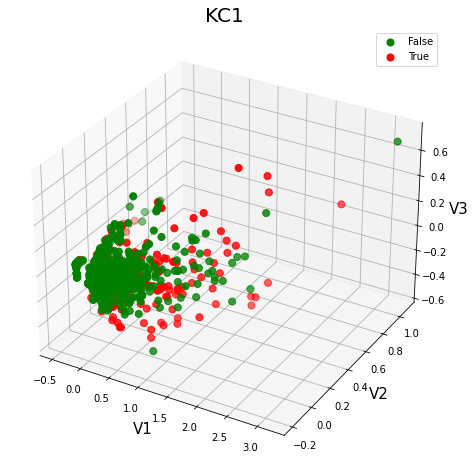

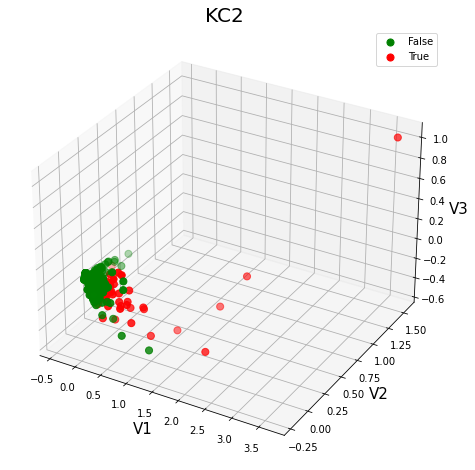

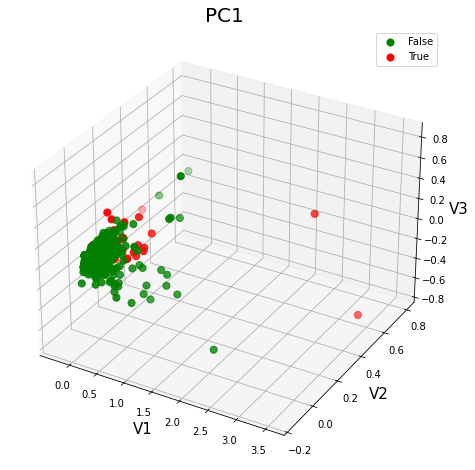

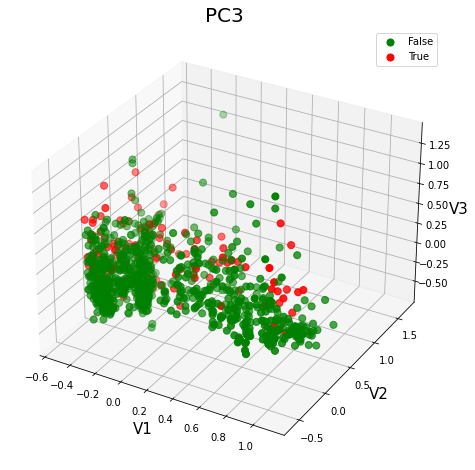

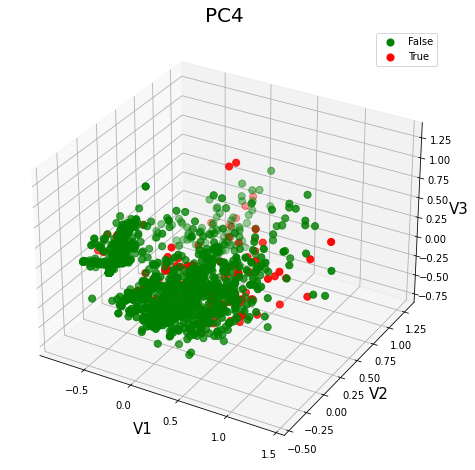

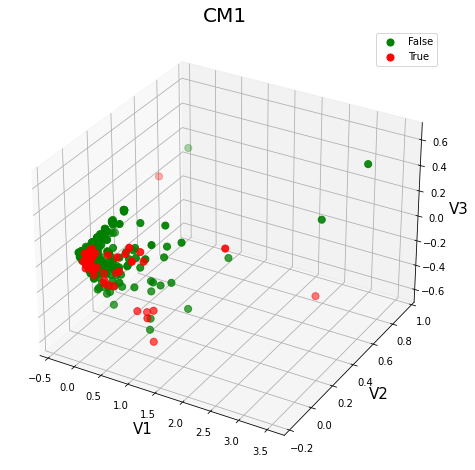

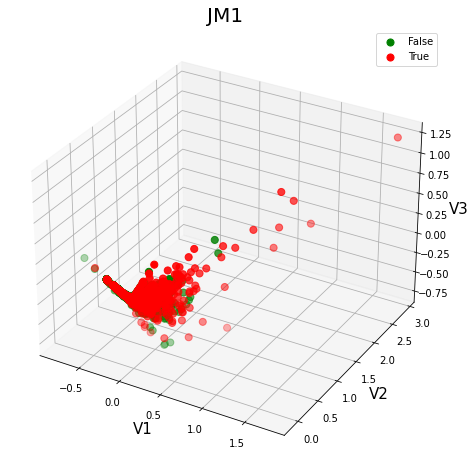

In [32]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
scaller = MinMaxScaler()


pca = PCA(n_components=3)
for i in dataset:
    data = dataset[i]
    x = data.loc[:, data.columns != 'defect'].values 
    x = scaller.fit_transform(x)

    
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['V1', 'V2','V3'])
    finalDf = pd.concat([principalDf, data[['defect']]], axis = 1)
    
    fig = plt.figure(figsize = (8,8))
    ax = plt.axes(projection ='3d') 
    ax.set_xlabel('V1', fontsize = 15)
    ax.set_ylabel('V2', fontsize = 15)
    ax.set_zlabel('V3', fontsize = 15) 
    ax.set_title(i, fontsize = 20)
    targets = [False, True]
    colors = ['g', 'r','b']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['defect'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'V1'], finalDf.loc[indicesToKeep, 'V2'],finalDf.loc[indicesToKeep, 'V3'], c = color, s = 50)
        ax.legend(targets)
        ax.grid()

# Check Defect Minimum Rate

In [33]:
dmr_data = {}
for i in dataset:
    unique, counts = np.unique(dataset[i]['defect'], return_counts=True)
    dmr = (round((counts[1]/(counts[0]+counts[1])*100),2))
    print(dmr, unique, counts)
    dmr_data[i] = dmr

15.46 [False  True] [1783  326]
20.5 [False  True] [415 107]
6.94 [False  True] [1032   77]
12.44 [False  True] [943 134]
12.21 [False  True] [1280  178]
9.84 [False  True] [449  49]
19.33 [False  True] [8777 2103]


# Penerapan Min-Max Scaller untuk mengubah variant distribusi
$$ x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}} $$

In [34]:

for i in dataset:
    dataset[i].loc[:, dataset[i].columns != dataset[i].columns[-1]] = scaller.fit_transform(dataset[i].loc[:, dataset[i].columns != dataset[i].columns[-1]])
#     display(dataset[i].loc[:, dataset[i].columns[0]:dataset[i].columns[4]].head(3))
    print(i)
    display(dataset[i])

KC1


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defect
0,0.000348,0.009091,0.016,0.009091,0.001175,0.000164,0.650,0.024186,0.006734,0.000004,...,0.007634,0.045455,0.034483,0.166667,0.032432,0.010000,0.001770,0.002804,0.004545,False
1,0.000000,0.000000,0.000,0.000000,0.000904,0.000126,0.500,0.018605,0.005180,0.000003,...,0.003817,0.022727,0.017241,0.083333,0.027027,0.008333,0.001475,0.002336,0.000000,True
2,0.285714,0.227273,0.000,0.227273,0.154611,0.117175,0.020,0.428651,0.208588,0.065820,...,0.248092,0.227273,0.103448,0.000000,0.486486,0.208333,0.157817,0.149533,0.227273,True
3,0.156794,0.159091,0.200,0.159091,0.127486,0.097209,0.035,0.276465,0.268362,0.035211,...,0.141221,0.045455,0.086207,0.000000,0.432432,0.233333,0.131268,0.121495,0.159091,True
4,0.083624,0.045455,0.000,0.045455,0.052441,0.032170,0.055,0.173953,0.141148,0.007334,...,0.080153,0.000000,0.034483,0.000000,0.297297,0.083333,0.060472,0.039720,0.045455,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104,0.062718,0.022727,0.000,0.022727,0.036166,0.022186,0.075,0.126884,0.133482,0.003688,...,0.045802,0.022727,0.034483,0.000000,0.270270,0.091667,0.036873,0.035047,0.022727,False
2105,0.076655,0.045455,0.080,0.045455,0.054250,0.035186,0.050,0.180279,0.148917,0.008315,...,0.068702,0.022727,0.034483,0.000000,0.324324,0.108333,0.057522,0.049065,0.045455,False
2106,0.003484,0.000000,0.000,0.000000,0.003617,0.001010,0.335,0.027907,0.027608,0.000037,...,0.000000,0.000000,0.000000,0.000000,0.081081,0.008333,0.004425,0.002336,0.000000,False
2107,0.041812,0.000000,0.000,0.000000,0.015371,0.007696,0.125,0.074419,0.078939,0.000751,...,0.022901,0.000000,0.086207,0.000000,0.162162,0.050000,0.013274,0.018692,0.000000,False


KC2


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,lOCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defect
0,0.000078,0.002235,0.003226,0.002817,0.000075,0.000038,0.650,0.012557,0.003132,6.053597e-07,...,0.001807,0.045455,0.016529,0.181818,0.004348,0.003692,0.000081,0.000793,0.001111,False
1,0.001570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000e+00,...,0.000903,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False
2,0.010204,0.005587,0.000000,0.007042,0.005275,0.002602,0.085,0.055926,0.036645,2.370868e-04,...,0.007227,0.000000,0.008264,0.000000,0.173913,0.021538,0.004862,0.005948,0.005556,False
3,0.007064,0.005587,0.000000,0.007042,0.004270,0.001908,0.070,0.067613,0.022214,2.103439e-04,...,0.007227,0.000000,0.000000,0.000000,0.152174,0.012308,0.004052,0.004627,0.005556,False
4,0.005495,0.000000,0.000000,0.000000,0.002261,0.000937,0.250,0.019318,0.038187,2.952293e-05,...,0.002710,0.000000,0.000000,0.090909,0.065217,0.015385,0.001621,0.003305,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,0.002355,0.000000,0.000000,0.000000,0.001005,0.000343,0.250,0.019318,0.013974,1.081266e-05,...,0.001807,0.000000,0.000000,0.000000,0.065217,0.003077,0.001216,0.000661,0.000000,True
518,0.002355,0.000000,0.000000,0.000000,0.000754,0.000237,0.335,0.014489,0.012842,5.587935e-06,...,0.001807,0.000000,0.000000,0.000000,0.043478,0.003077,0.000810,0.000661,0.000000,True
519,0.002355,0.000000,0.000000,0.000000,0.000754,0.000237,0.335,0.014489,0.012842,5.587935e-06,...,0.001807,0.000000,0.000000,0.000000,0.043478,0.003077,0.000810,0.000661,0.000000,True
520,0.002355,0.000000,0.000000,0.000000,0.001005,0.000343,0.335,0.014489,0.018648,8.107163e-06,...,0.001807,0.000000,0.000000,0.000000,0.043478,0.006154,0.000810,0.001322,0.000000,True


PC1


,loc,v(g),ev(g),iv(G),N,V,L,D,I,E,...,lOCode,lOComment,locCodeAndComment,lOBlank,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defect
0,0.001827,0.002963,0.003279,0.003279,0.000108,0.000050,0.650,0.004803,0.002173,3.037644e-07,...,0.003333,0.012579,0.041667,0.008889,0.002041,0.002230,0.000122,0.001049,0.001702,False
1,0.001661,0.000000,0.000000,0.000000,0.000000,0.000039,0.500,0.003695,0.001671,2.336649e-07,...,0.001667,0.006289,0.020833,0.004444,0.000000,0.001859,0.000000,0.000874,0.000000,True
2,0.151163,0.059259,0.016393,0.008197,0.113865,0.080532,0.020,0.102269,0.126134,1.351360e-02,...,0.133333,0.276730,0.229167,0.137778,0.285714,0.122677,0.116463,0.110140,0.068085,True
3,0.181063,0.148148,0.032787,0.139344,0.136494,0.098200,0.020,0.104818,0.150068,1.688992e-02,...,0.161667,0.257862,0.250000,0.106667,0.275510,0.139405,0.139024,0.132867,0.157447,True
4,0.838870,0.777778,0.327869,0.663934,0.839799,0.797794,0.005,0.280536,0.455568,3.672060e-01,...,0.761667,0.446541,1.000000,0.217778,0.642857,0.737918,0.851220,0.823427,0.753191,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,0.009967,0.022222,0.024590,0.000000,0.008980,0.003709,0.040,0.049250,0.012067,2.997500e-04,...,0.010000,0.000000,0.000000,0.008889,0.091837,0.005576,0.010366,0.006993,0.025532,False
1105,0.016611,0.029630,0.032787,0.000000,0.015086,0.007041,0.025,0.077588,0.014540,8.963105e-04,...,0.016667,0.000000,0.000000,0.004444,0.132653,0.009294,0.016463,0.013112,0.034043,False
1106,0.008306,0.014815,0.016393,0.000000,0.005747,0.002425,0.105,0.017734,0.021911,7.055745e-05,...,0.008333,0.000000,0.000000,0.000000,0.071429,0.009294,0.006098,0.005245,0.017021,False
1107,0.029900,0.051852,0.032787,0.032787,0.039511,0.023634,0.020,0.084682,0.044708,3.283123e-03,...,0.030000,0.000000,0.000000,0.004444,0.214286,0.044610,0.036585,0.043706,0.059574,False


PC3


,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,...,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,defect
0,0.207792,0.020408,0.041667,0.142857,0.141026,0.013986,0.020134,0.186992,0.010563,0.166667,...,0.015609,0.055276,0.016447,0.013608,0.036943,0.265625,0.062921,0.452416,0.035496,False
1,0.012987,0.020408,0.208333,0.000000,0.000000,0.015734,0.020134,0.292683,0.014085,0.066667,...,0.021852,0.160804,0.008971,0.008594,0.021656,0.234375,0.022472,0.000000,0.023256,False
2,0.103896,0.003401,0.041667,0.000000,0.012821,0.000000,0.003356,0.105691,0.000000,0.000000,...,0.004162,0.035176,0.007476,0.005909,0.021656,0.140625,0.025843,0.071003,0.017136,False
3,0.012987,0.006803,0.083333,0.023810,0.012821,0.001748,0.006711,0.113821,0.000000,0.333333,...,0.007284,0.060302,0.006230,0.005013,0.021656,0.156250,0.024719,0.101341,0.024480,False
4,0.181818,0.017007,0.291667,0.000000,0.179487,0.013986,0.016779,0.162602,0.014085,0.000000,...,0.023933,0.045226,0.016696,0.015577,0.036943,0.234375,0.064045,0.346604,0.035496,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,0.000000,0.006803,0.250000,0.023810,0.000000,0.001748,0.006711,0.097561,0.000000,0.333333,...,0.012487,0.055276,0.017194,0.013071,0.045860,0.234375,0.026966,0.044390,0.029376,True
1073,0.129870,0.085034,0.083333,0.142857,0.012821,0.083916,0.083893,0.430894,0.084507,0.000000,...,0.126951,0.211055,0.108647,0.105282,0.112102,0.171875,0.066292,0.152118,0.058752,True
1074,0.454545,0.052721,0.458333,0.023810,0.025641,0.027972,0.067114,0.170732,0.024648,0.083333,...,0.055151,0.075377,0.028408,0.027037,0.071338,0.437500,0.147191,0.033319,0.115055,True
1075,0.220779,0.017007,0.000000,0.119048,0.256410,0.013986,0.016779,0.146341,0.014085,0.000000,...,0.016649,0.040201,0.015201,0.013429,0.025478,0.265625,0.076404,0.521822,0.037944,True


PC4


,LOC_BLANK,BRANCH_COUNT,CALL_PAIRS,LOC_CODE_AND_COMMENT,LOC_COMMENTS,CONDITION_COUNT,CYCLOMATIC_COMPLEXITY,CYCLOMATIC_DENSITY,DECISION_COUNT,DECISION_DENSITY,...,NODE_COUNT,NORMALIZED_CYLOMATIC_COMPLEXITY,NUM_OPERANDS,NUM_OPERATORS,NUM_UNIQUE_OPERANDS,NUM_UNIQUE_OPERATORS,NUMBER_OF_LINES,PERCENT_COMMENTS,LOC_TOTAL,defect
0,0.188889,0.053763,0.208333,0.029412,0.102564,0.053763,0.053763,0.029240,0.053763,0.4,...,0.080986,0.048035,0.037776,0.029046,0.038270,0.315789,0.069913,0.335949,0.114286,False
1,0.022222,0.043011,0.125000,0.000000,0.012821,0.043011,0.043011,0.065497,0.032258,0.4,...,0.042254,0.157205,0.009266,0.014226,0.011647,0.368421,0.016230,0.107504,0.042857,False
2,0.022222,0.021505,0.041667,0.014706,0.012821,0.016129,0.021505,0.019883,0.010753,0.6,...,0.017606,0.056769,0.011404,0.016598,0.014975,0.368421,0.027466,0.113201,0.085714,False
3,0.044444,0.021505,0.041667,0.000000,0.000000,0.021505,0.021505,0.035088,0.021505,0.4,...,0.028169,0.082969,0.009266,0.009484,0.016639,0.236842,0.018727,0.000000,0.047619,False
4,0.077778,0.021505,0.041667,0.044118,0.000000,0.000000,0.021505,0.017544,0.000000,0.0,...,0.028169,0.048035,0.018532,0.027267,0.011647,0.184211,0.033708,0.161256,0.095238,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,0.011111,0.032258,0.083333,0.000000,0.000000,0.000000,0.032258,0.046784,0.000000,0.0,...,0.042254,0.135371,0.009266,0.020747,0.009983,0.263158,0.014981,0.000000,0.047619,False
1454,0.133333,0.010753,0.333333,0.000000,0.076923,0.010753,0.010753,0.012865,0.010753,0.4,...,0.042254,0.021834,0.019957,0.023711,0.031614,0.342105,0.047441,0.258009,0.090476,False
1455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.116959,0.000000,0.0,...,0.000000,0.436681,0.000000,0.001186,0.000000,0.052632,0.000000,0.000000,0.000000,False
1456,0.088889,0.043011,0.000000,0.000000,0.128205,0.000000,0.043011,0.049123,0.000000,0.0,...,0.028169,0.069869,0.014255,0.022525,0.014975,0.526316,0.038702,0.488605,0.057143,False


CM1


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defect
0,0.000237,0.004211,0.013793,0.006452,0.000145,0.000076,1.000000,0.010336,0.004427,6.036150e-07,...,0.0250,0.005900,0.012195,1.0,0.002817,0.003822,0.000159,0.001474,0.002484,False
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000058,0.769231,0.007951,0.003405,4.643192e-07,...,0.0125,0.002950,0.006098,0.5,0.000000,0.003185,0.000000,0.001229,0.000000,True
2,0.054502,0.042105,0.000000,0.032258,0.029894,0.018052,0.084615,0.075535,0.110801,1.363599e-03,...,0.0125,0.000000,0.036585,0.0,0.197183,0.047771,0.034127,0.023342,0.049689,False
3,0.045024,0.031579,0.103448,0.016129,0.022179,0.012584,0.046154,0.127216,0.045866,1.600922e-03,...,0.0000,0.000000,0.018293,0.0,0.211268,0.025478,0.023810,0.019656,0.037267,False
4,0.054502,0.052632,0.172414,0.016129,0.034233,0.020213,0.046154,0.137791,0.067999,2.785720e-03,...,0.0000,0.000000,0.018293,0.0,0.211268,0.038217,0.035714,0.031941,0.062112,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0.109005,0.021053,0.000000,0.032258,0.122951,0.091319,0.030769,0.222629,0.190173,2.033064e-02,...,0.0250,0.038348,0.012195,0.0,0.309859,0.146497,0.113492,0.137592,0.024845,True
494,0.054502,0.031579,0.068966,0.032258,0.051109,0.034316,0.038462,0.152103,0.104604,5.219682e-03,...,0.0125,0.020649,0.024390,0.0,0.295775,0.073248,0.052381,0.049140,0.037267,True
495,0.191943,0.105263,0.068966,0.145161,0.228544,0.184290,0.015385,0.355490,0.240364,6.550813e-02,...,0.1125,0.174041,0.213415,0.0,0.436620,0.216561,0.225397,0.233415,0.124224,True
496,0.021327,0.010526,0.000000,0.000000,0.014947,0.008783,0.115385,0.051682,0.078793,4.539603e-04,...,0.0125,0.035398,0.024390,0.0,0.169014,0.041401,0.014286,0.015971,0.012422,True


JM1


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defect
0,0.000029,0.000853,0.002439,0.000998,0.000154,0.000016,1.000000,0.003109,0.002282,4.182783e-08,...,0.000708,0.005814,0.004474,0.018519,0.002920,0.001170,0.000221,0.000397,0.000485,False
1,0.000000,0.000000,0.000000,0.000000,0.000118,0.000012,0.769231,0.002391,0.001755,3.217526e-08,...,0.000354,0.002907,0.002237,0.009259,0.002433,0.000975,0.000185,0.000331,0.000000,True
2,0.020634,0.012793,0.000000,0.012469,0.023457,0.014029,0.038462,0.048565,0.098020,7.409672e-04,...,0.018059,0.029070,0.017897,0.009259,0.041363,0.035088,0.020664,0.028467,0.014545,True
3,0.054926,0.004264,0.000000,0.004988,0.071082,0.053793,0.046154,0.040794,0.447313,2.387490e-03,...,0.045680,0.084302,0.062640,0.018519,0.041363,0.131579,0.060701,0.089705,0.004848,True
4,0.010462,0.006397,0.000000,0.007481,0.014927,0.007411,0.046154,0.041105,0.061182,3.313183e-04,...,0.009915,0.002907,0.013423,0.000000,0.026764,0.015595,0.014022,0.016551,0.007273,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10880,0.004940,0.006397,0.000000,0.007481,0.006160,0.002987,0.107692,0.017527,0.057794,5.697788e-05,...,0.004603,0.000000,0.004474,0.000000,0.024331,0.014620,0.005535,0.007282,0.007273,False
10881,0.002325,0.002132,0.000000,0.002494,0.003554,0.001604,0.092308,0.019727,0.027590,3.441723e-05,...,0.001771,0.000000,0.004474,0.000000,0.029197,0.007797,0.003506,0.003641,0.002424,False
10882,0.011915,0.006397,0.000000,0.002494,0.012202,0.006427,0.030769,0.063128,0.034540,4.413390e-04,...,0.010269,0.002907,0.022371,0.000000,0.043796,0.014620,0.010886,0.014565,0.007273,False
10883,0.002616,0.000000,0.000000,0.000000,0.004265,0.001820,0.092308,0.020182,0.030608,3.994783e-05,...,0.002125,0.000000,0.004474,0.000000,0.021898,0.007797,0.003875,0.004965,0.000000,False


# Load Data to 10 Cross Validation

In [35]:
data_load = {}
for i in dataset:
    data_load[i] = tool.load_data(dataset[i])

# SMOTE

In [11]:
def SMOTUNE(X_train, y_train, sampling, neighbors):
    neighbors = int(neighbors)
    sm = SMOTE(random_state=42, sampling_strategy=sampling, k_neighbors=neighbors)
    X_train, y_train = sm.fit_sample(X_train, y_train)
    return X_train, y_train

# Bayesian Optimization

In [12]:
from bayes_opt import UtilityFunction

def optimize(model, pbounds, init = 15, iter = 35):
    repro()
    utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

    optimizer = bayesopt(
        f=model,
        pbounds=pbounds,
        verbose=2,
        random_state=42,
    )

#     max = 0
#     for i in range(iter):

#         print("\n======== ITERASI ",i," =========")
#         if(i < init):
#             next_point = tool.generate_random_sample(pbounds)
#         else:
#             next_point = optimizer.suggest(utility)


#         target = model(**next_point)
#         optimizer.register(params=next_point, target=target)
        
#         print(target)
#         if(target > max):
#             max = target
#             print("\x1b[31m",target,next_point,"\x1b[0m")
#         else:
#             print(target, next_point)
    optimizer.maximize(init_points=init, n_iter=iter, acq='ei')

    return optimizer

# Tie all it Together

In [106]:
from tensorflow.keras.utils import plot_model
from imblearn.over_sampling import SMOTE
test = []
def run_nn(data, fold, pbounds, do_optimize = True):
    repro()
    fold_generator = tool.split(data, fold)
    sm = SMOTE(random_state=42)

    
    def go(do_optimize = True, **pbounds):
        
        y_train_pred_collect, y_dev_pred_collect, y_test_pred_collect = [], [], []
        y_train_true_collect, y_dev_true_collect, y_test_true_collect = [], [], []
        models = model.neuralNet(**pbounds)
        
        
        
        for remainder, test in fold_generator():
            repro()
            train, dev = next(tool.split(remainder, fold)())

            X_train, y_train = train[0], train[1]
            X_dev, y_dev = dev[0], dev[1]
            X_test, y_test = test[0],test[1]
            
            if 'sampling' and 'neighbors' in pbounds:
                X_train, y_train = SMOTUNE(X_train, y_train, 1, 5)

            models.fit(X_train, y_train, epochs = 15, batch_size = 64, verbose = 0)


            #Collect Train Dev Test
    
            y_train_pred_collect = np.append(y_train_pred_collect, models.predict(X_train).round())
            y_train_true_collect = np.append(y_train_true_collect, y_train)
            
            y_dev_pred_collect = np.append(y_dev_pred_collect, models.predict(X_dev).round())
            y_dev_true_collect = np.append(y_dev_true_collect, y_dev)
            
            y_test_pred_collect = np.append(y_test_pred_collect, models.predict(X_test).round())
            y_test_true_collect = np.append(y_test_true_collect, y_test)

        
        if(do_optimize):
            result = metric.gmeans(y_dev_true_collect, y_dev_pred_collect)
        else:

            result = {
                "Train" : {
                    "Gmeans" : metric.gmeans(y_train_true_collect, y_train_pred_collect),
                    "Recall" : metric.recall(y_train_true_collect, y_train_pred_collect),
                    "pf" : metric.pf(y_train_true_collect, y_train_pred_collect),
                    "cf_matrix" : metric.conf_matrix(y_train_true_collect, y_train_pred_collect)
                },
                "Dev" : {
                    "Gmeans" : metric.gmeans(y_dev_true_collect, y_dev_pred_collect),
                    "Recall" : metric.recall(y_dev_true_collect, y_dev_pred_collect),
                    "pf" : metric.pf(y_dev_true_collect, y_dev_pred_collect),
                    "cf_matrix" : metric.conf_matrix(y_dev_true_collect, y_dev_pred_collect)
                },
                "Test" : {
                    "Gmeans" : metric.gmeans(y_test_true_collect, y_test_pred_collect),
                    "Recall" : metric.recall(y_test_true_collect, y_test_pred_collect),
                    "pf" : metric.pf(y_test_true_collect, y_test_pred_collect),
                    "cf_matrix" : metric.conf_matrix(y_test_true_collect, y_test_pred_collect)
                }
                
            }
        return result
        
    if(do_optimize):
        return optimize(go, pbounds, init = 15, iter = 35)
    else:
        return go(do_optimize = False, **pbounds)
        

# Define Hyperparam Search Space

In [37]:
bound = {}
for i in dataset:
    bound[i] = {'lr': (0.001, 0.01),
           'drop': (0.1, 0.6),
           'layer': (1, 5),
           'neurons': (1, 50),
           'sampling': ((dmr_data[i]/100)+0.1,1),
           'neighbors': (1,20)
          }

bound_without_smote = {'lr': (0.001, 0.01),
           'drop': (0.1, 0.6),
           'layer': (1, 5),
           'neurons': (1, 50)
          }

# Let's Optimize it

## With SMOTE

### KC1

In [15]:
hyperparam_KC1 = run_nn(data_load['KC1'], 10, bound['KC1'])

|   iter    |  target   |   drop    |   layer   |    lr     | neighbors |  neurons  | sampling  |
-------------------------------------------------------------------------------------------------
|  1        |  0.3683   |  0.2873   |  4.803    |  0.007588 |  12.37    |  8.645    |  0.3709   |
|  2        |  0.0      |  0.129    |  4.465    |  0.00641  |  14.45    |  2.009    |  0.9776   |
|  3        |  0.6941   |  0.5162   |  1.849    |  0.002636 |  4.485    |  15.91    |  0.6458   |
|  4        |  0.6677   |  0.316    |  2.165    |  0.006507 |  3.65     |  15.32    |  0.5277   |
|  5        |  0.6135   |  0.328    |  4.141    |  0.002797 |  10.77    |  30.03    |  0.2892   |
|  6        |  0.7368   |  0.4038   |  1.682    |  0.001585 |  19.03    |  48.32    |  0.8572   |
|  7        |  0.6737   |  0.2523   |  1.391    |  0.007158 |  9.363    |  6.98     |  0.6237   |
|  8        |  0.6811   |  0.1172   |  4.637    |  0.003329 |  13.59    |  16.27    |  0.6423   |
|  9        |  0.735

In [16]:
best_hyperparam_KC1 = hyperparam_KC1.max['params']
result_KC1 = run_nn(data_load['KC1'], 10, best_hyperparam_KC1, do_optimize = False)
result_KC1

{'Train': {'Gmeans': 0.723049805084308,
  'Recall': 0.75301288267073,
  'pf': 0.30572101399085744,
  'cf_matrix': {'tn': 10024, 'fp': 4414, 'fn': 3566, 'tp': 10872}},
 'Dev': {'Gmeans': 0.7395543529888927,
  'Recall': 0.8178694158075601,
  'pf': 0.3312616532007458,
  'cf_matrix': {'tn': 1076, 'fp': 533, 'fn': 53, 'tp': 238}},
 'Test': {'Gmeans': 0.7143818048100088,
  'Recall': 0.7361963190184049,
  'pf': 0.30678631519910265,
  'cf_matrix': {'tn': 1236, 'fp': 547, 'fn': 86, 'tp': 240}}}

### KC2

In [17]:
hyperparam_KC2 = run_nn(data_load['KC2'], 10, bound['KC2'])

|   iter    |  target   |   drop    |   layer   |    lr     | neighbors |  neurons  | sampling  |
-------------------------------------------------------------------------------------------------
|  1        |  0.7572   |  0.2873   |  4.803    |  0.007588 |  12.37    |  8.645    |  0.4134   |
|  2        |  0.7804   |  0.129    |  4.465    |  0.00641  |  14.45    |  2.009    |  0.9791   |
|  3        |  0.8321   |  0.5162   |  1.849    |  0.002636 |  4.485    |  15.91    |  0.6697   |
|  4        |  0.8149   |  0.316    |  2.165    |  0.006507 |  3.65     |  15.32    |  0.5596   |
|  5        |  0.7508   |  0.328    |  4.141    |  0.002797 |  10.77    |  30.03    |  0.3373   |
|  6        |  0.8084   |  0.4038   |  1.682    |  0.001585 |  19.03    |  48.32    |  0.8668   |
|  7        |  0.8334   |  0.2523   |  1.391    |  0.007158 |  9.363    |  6.98     |  0.6491   |
|  8        |  0.8353   |  0.1172   |  4.637    |  0.003329 |  13.59    |  16.27    |  0.6664   |
|  9        |  0.804

In [18]:
best_hyperparam_KC2 = hyperparam_KC2.max['params']
result_KC2 = run_nn(data_load['KC2'], 10, best_hyperparam_KC2, do_optimize = False)
result_KC2

{'Train': {'Gmeans': 0.8817092540422861,
  'Recall': 0.8956780923994039,
  'pf': 0.13204172876304024,
  'cf_matrix': {'tn': 2912, 'fp': 443, 'fn': 350, 'tp': 3005}},
 'Dev': {'Gmeans': 0.8498365855987975,
  'Recall': 0.8444444444444444,
  'pf': 0.14473684210526316,
  'cf_matrix': {'tn': 325, 'fp': 55, 'fn': 14, 'tp': 76}},
 'Test': {'Gmeans': 0.8183240911811218,
  'Recall': 0.7850467289719626,
  'pf': 0.14698795180722893,
  'cf_matrix': {'tn': 354, 'fp': 61, 'fn': 23, 'tp': 84}}}

### PC1

In [19]:
hyperparam_PC1 = run_nn(data_load['PC1'], 5, bound['PC1'])

|   iter    |  target   |   drop    |   layer   |    lr     | neighbors |  neurons  | sampling  |
-------------------------------------------------------------------------------------------------
|  1        |  0.3346   |  0.2873   |  4.803    |  0.007588 |  12.37    |  8.645    |  0.299    |
|  2        |  0.0      |  0.129    |  4.465    |  0.00641  |  14.45    |  2.009    |  0.975    |
|  3        |  0.5658   |  0.5162   |  1.849    |  0.002636 |  4.485    |  15.91    |  0.6053   |
|  4        |  0.7472   |  0.316    |  2.165    |  0.006507 |  3.65     |  15.32    |  0.4737   |
|  5        |  0.5141   |  0.328    |  4.141    |  0.002797 |  10.77    |  30.03    |  0.208    |
|  6        |  0.6491   |  0.4038   |  1.682    |  0.001585 |  19.03    |  48.32    |  0.8409   |
|  7        |  0.6262   |  0.2523   |  1.391    |  0.007158 |  9.363    |  6.98     |  0.5807   |
|  8        |  0.8116   |  0.1172   |  4.637    |  0.003329 |  13.59    |  16.27    |  0.6014   |
|  9        |  0.796

In [20]:
best_hyperparam_PC1 = hyperparam_PC1.max['params']
result_PC1 = run_nn(data_load['PC1'], 5, best_hyperparam_PC1, do_optimize = False)
result_PC1

{'Train': {'Gmeans': 0.9087438651637247,
  'Recall': 0.9729349736379613,
  'pf': 0.15121212121212121,
  'cf_matrix': {'tn': 2801, 'fp': 499, 'fn': 77, 'tp': 2768}},
 'Dev': {'Gmeans': 0.8529139521401543,
  'Recall': 0.8870967741935484,
  'pf': 0.17995169082125603,
  'cf_matrix': {'tn': 679, 'fp': 149, 'fn': 7, 'tp': 55}},
 'Test': {'Gmeans': 0.7895101558035741,
  'Recall': 0.7532467532467533,
  'pf': 0.17248062015503876,
  'cf_matrix': {'tn': 854, 'fp': 178, 'fn': 19, 'tp': 58}}}

### PC3

In [21]:
hyperparam_PC3 = run_nn(data_load['PC3'], 7, bound['PC3'])

|   iter    |  target   |   drop    |   layer   |    lr     | neighbors |  neurons  | sampling  |
-------------------------------------------------------------------------------------------------
|  1        |  0.6114   |  0.2873   |  4.803    |  0.007588 |  12.37    |  8.645    |  0.3454   |
|  2        |  0.7411   |  0.129    |  4.465    |  0.00641  |  14.45    |  2.009    |  0.9767   |
|  3        |  0.7425   |  0.5162   |  1.849    |  0.002636 |  4.485    |  15.91    |  0.6314   |
|  4        |  0.7231   |  0.316    |  2.165    |  0.006507 |  3.65     |  15.32    |  0.5086   |
|  5        |  0.6868   |  0.328    |  4.141    |  0.002797 |  10.77    |  30.03    |  0.2604   |
|  6        |  0.7287   |  0.4038   |  1.682    |  0.001585 |  19.03    |  48.32    |  0.8514   |
|  7        |  0.7177   |  0.2523   |  1.391    |  0.007158 |  9.363    |  6.98     |  0.6085   |
|  8        |  0.7491   |  0.1172   |  4.637    |  0.003329 |  13.59    |  16.27    |  0.6278   |
|  9        |  0.746

In [22]:
best_hyperparam_PC3 = hyperparam_PC3.max['params']
result_PC3 = run_nn(data_load['PC3'], 7, best_hyperparam_PC3, do_optimize = False)
result_PC3

{'Train': {'Gmeans': 0.8593358420317677,
  'Recall': 0.9382716049382716,
  'pf': 0.21295914156004953,
  'cf_matrix': {'tn': 3814, 'fp': 1032, 'fn': 230, 'tp': 3496}},
 'Dev': {'Gmeans': 0.7748351167365085,
  'Recall': 0.8125,
  'pf': 0.26108374384236455,
  'cf_matrix': {'tn': 600, 'fp': 212, 'fn': 21, 'tp': 91}},
 'Test': {'Gmeans': 0.8057480934067718,
  'Recall': 0.8432835820895522,
  'pf': 0.2301166489925769,
  'cf_matrix': {'tn': 726, 'fp': 217, 'fn': 21, 'tp': 113}}}

### PC4

In [23]:
hyperparam_PC4 = run_nn(data_load['PC4'], 7, bound['PC4'])

|   iter    |  target   |   drop    |   layer   |    lr     | neighbors |  neurons  | sampling  |
-------------------------------------------------------------------------------------------------
|  1        |  0.8419   |  0.2873   |  4.803    |  0.007588 |  12.37    |  8.645    |  0.3434   |
|  2        |  0.832    |  0.129    |  4.465    |  0.00641  |  14.45    |  2.009    |  0.9766   |
|  3        |  0.7968   |  0.5162   |  1.849    |  0.002636 |  4.485    |  15.91    |  0.6303   |
|  4        |  0.8175   |  0.316    |  2.165    |  0.006507 |  3.65     |  15.32    |  0.5071   |
|  5        |  0.76     |  0.328    |  4.141    |  0.002797 |  10.77    |  30.03    |  0.2582   |
|  6        |  0.8301   |  0.4038   |  1.682    |  0.001585 |  19.03    |  48.32    |  0.851    |
|  7        |  0.8185   |  0.2523   |  1.391    |  0.007158 |  9.363    |  6.98     |  0.6073   |
|  8        |  0.805    |  0.1172   |  4.637    |  0.003329 |  13.59    |  16.27    |  0.6267   |
|  9        |  0.827

In [24]:
best_hyperparam_PC4 = hyperparam_PC4.max['params']
result_PC4 = run_nn(data_load['PC4'], 7, best_hyperparam_PC4, do_optimize = False)
result_PC4

{'Train': {'Gmeans': 0.9090480655572883,
  'Recall': 0.9673301929797903,
  'pf': 0.1457225345692144,
  'cf_matrix': {'tn': 5622, 'fp': 959, 'fn': 215, 'tp': 6366}},
 'Dev': {'Gmeans': 0.8726774916967546,
  'Recall': 0.8961038961038961,
  'pf': 0.15013648771610555,
  'cf_matrix': {'tn': 934, 'fp': 165, 'fn': 16, 'tp': 138}},
 'Test': {'Gmeans': 0.8784342716805403,
  'Recall': 0.9044943820224719,
  'pf': 0.146875,
  'cf_matrix': {'tn': 1092, 'fp': 188, 'fn': 17, 'tp': 161}}}

## CM1

In [17]:
hyperparam_CM1 = run_nn(data_load['CM1'], 5, bound['CM1'])

|   iter    |  target   |   drop    |   layer   |    lr     | neighbors |  neurons  | sampling  |
-------------------------------------------------------------------------------------------------
|  1        |  0.5425   |  0.2873   |  4.803    |  0.007588 |  12.37    |  8.645    |  0.3234   |
|  2        |  0.0      |  0.129    |  4.465    |  0.00641  |  14.45    |  2.009    |  0.9759   |
|  3        |  0.6625   |  0.5162   |  1.849    |  0.002636 |  4.485    |  15.91    |  0.619    |
|  4        |  0.6691   |  0.316    |  2.165    |  0.006507 |  3.65     |  15.32    |  0.4921   |
|  5        |  0.434    |  0.328    |  4.141    |  0.002797 |  10.77    |  30.03    |  0.2356   |
|  6        |  0.7399   |  0.4038   |  1.682    |  0.001585 |  19.03    |  48.32    |  0.8464   |
|  7        |  0.6735   |  0.2523   |  1.391    |  0.007158 |  9.363    |  6.98     |  0.5953   |
|  8        |  0.6807   |  0.1172   |  4.637    |  0.003329 |  13.59    |  16.27    |  0.6153   |
|  9        |  0.777

In [18]:
best_hyperparam_CM1 = hyperparam_CM1.max['params']
result_CM1 = run_nn(data_load['CM1'], 5, best_hyperparam_CM1, do_optimize = False)
result_CM1

{'Train': {'Gmeans': 0.822853142246565,
  'Recall': 0.9268802228412256,
  'pf': 0.2694986072423398,
  'cf_matrix': {'tn': 1049, 'fp': 387, 'fn': 105, 'tp': 1331}},
 'Dev': {'Gmeans': 0.7850159234053791,
  'Recall': 0.85,
  'pf': 0.275,
  'cf_matrix': {'tn': 261, 'fp': 99, 'fn': 6, 'tp': 34}},
 'Test': {'Gmeans': 0.7601860453257626,
  'Recall': 0.7959183673469388,
  'pf': 0.2739420935412027,
  'cf_matrix': {'tn': 326, 'fp': 123, 'fn': 10, 'tp': 39}}}

## JM1

In [19]:
hyperparam_JM1 = run_nn(data_load['JM1'], 10, bound['JM1'])

|   iter    |  target   |   drop    |   layer   |    lr     | neighbors |  neurons  | sampling  |
-------------------------------------------------------------------------------------------------
|  1        |  0.3917   |  0.2873   |  4.803    |  0.007588 |  12.37    |  8.645    |  0.4035   |
|  2        |  0.6438   |  0.129    |  4.465    |  0.00641  |  14.45    |  2.009    |  0.9787   |
|  3        |  0.5884   |  0.5162   |  1.849    |  0.002636 |  4.485    |  15.91    |  0.6641   |
|  4        |  0.5781   |  0.316    |  2.165    |  0.006507 |  3.65     |  15.32    |  0.5522   |
|  5        |  0.3574   |  0.328    |  4.141    |  0.002797 |  10.77    |  30.03    |  0.3261   |
|  6        |  0.6416   |  0.4038   |  1.682    |  0.001585 |  19.03    |  48.32    |  0.8646   |
|  7        |  0.5959   |  0.2523   |  1.391    |  0.007158 |  9.363    |  6.98     |  0.6432   |
|  8        |  0.6195   |  0.1172   |  4.637    |  0.003329 |  13.59    |  16.27    |  0.6608   |
|  9        |  0.651

In [20]:
best_hyperparam_JM1 = hyperparam_JM1.max['params']
result_JM1 = run_nn(data_load['JM1'], 10, best_hyperparam_JM1, do_optimize = False)
result_JM1

{'Train': {'Gmeans': 0.6911245033954088,
  'Recall': 0.7004205758654157,
  'pf': 0.31804819039849214,
  'cf_matrix': {'tn': 48482, 'fp': 22611, 'fn': 21298, 'tp': 49795}},
 'Dev': {'Gmeans': 0.656421008936098,
  'Recall': 0.6426315789473684,
  'pf': 0.32949367088607595,
  'cf_matrix': {'tn': 5297, 'fp': 2603, 'fn': 679, 'tp': 1221}},
 'Test': {'Gmeans': 0.6652888772800339,
  'Recall': 0.6504992867332382,
  'pf': 0.31958527970832856,
  'cf_matrix': {'tn': 5972, 'fp': 2805, 'fn': 735, 'tp': 1368}}}

## Without SMOTE

### KC1

In [2]:
int(70.90)

70

In [25]:
hyperparam_KC1_wihout_SMOTE = run_nn(data_load['KC1'], 10, bound_without_smote)

|   iter    |  target   |   drop    |   layer   |    lr     |  neurons  |
-------------------------------------------------------------------------
|  1        |  0.4075   |  0.2873   |  4.803    |  0.007588 |  30.33    |
|  2        |  0.5134   |  0.178    |  1.624    |  0.001523 |  43.44    |
|  3        |  0.533    |  0.4006   |  3.832    |  0.001185 |  48.53    |
|  4        |  0.3854   |  0.5162   |  1.849    |  0.002636 |  9.987    |
|  5        |  0.4031   |  0.2521   |  3.099    |  0.004888 |  15.27    |
|  6        |  0.4643   |  0.4059   |  1.558    |  0.003629 |  18.95    |
|  7        |  0.4859   |  0.328    |  4.141    |  0.002797 |  26.2     |
|  8        |  0.4541   |  0.3962   |  1.186    |  0.006468 |  9.356    |
|  9        |  0.5313   |  0.1325   |  4.796    |  0.009691 |  40.61    |
|  10       |  0.5358   |  0.2523   |  1.391    |  0.007158 |  22.57    |
|  11       |  0.5598   |  0.161    |  2.981    |  0.001309 |  45.56    |
|  12       |  0.5053   |  0.2294   | 

In [26]:
best_hyperparam_KC1_without_SMOTE = hyperparam_KC1_wihout_SMOTE.max['params']
result_KC1_without_SMOTE = run_nn(data_load['KC1'], 10, best_hyperparam_KC1_without_SMOTE, do_optimize = False)
result_KC1_without_SMOTE

{'Train': {'Gmeans': 0.5855802526192063,
  'Recall': 0.3518728717366629,
  'pf': 0.025488294777670038,
  'cf_matrix': {'tn': 14070, 'fp': 368, 'fn': 1713, 'tp': 930}},
 'Dev': {'Gmeans': 0.6127313425066456,
  'Recall': 0.3917525773195876,
  'pf': 0.041640770665009326,
  'cf_matrix': {'tn': 1542, 'fp': 67, 'fn': 177, 'tp': 114}},
 'Test': {'Gmeans': 0.5648232347679145,
  'Recall': 0.3312883435582822,
  'pf': 0.03701626472237801,
  'cf_matrix': {'tn': 1717, 'fp': 66, 'fn': 218, 'tp': 108}}}

### KC2

In [27]:
hyperparam_KC2_wihout_SMOTE = run_nn(data_load['KC2'], 10, bound_without_smote)

|   iter    |  target   |   drop    |   layer   |    lr     |  neurons  |
-------------------------------------------------------------------------
|  1        |  0.6997   |  0.2873   |  4.803    |  0.007588 |  30.33    |
|  2        |  0.6695   |  0.178    |  1.624    |  0.001523 |  43.44    |
|  3        |  0.6955   |  0.4006   |  3.832    |  0.001185 |  48.53    |
|  4        |  0.6429   |  0.5162   |  1.849    |  0.002636 |  9.987    |
|  5        |  0.7513   |  0.2521   |  3.099    |  0.004888 |  15.27    |
|  6        |  0.6624   |  0.4059   |  1.558    |  0.003629 |  18.95    |
|  7        |  0.6774   |  0.328    |  4.141    |  0.002797 |  26.2     |
|  8        |  0.6871   |  0.3962   |  1.186    |  0.006468 |  9.356    |
|  9        |  0.6968   |  0.1325   |  4.796    |  0.009691 |  40.61    |
|  10       |  0.7092   |  0.2523   |  1.391    |  0.007158 |  22.57    |
|  11       |  0.6824   |  0.161    |  2.981    |  0.001309 |  45.56    |
|  12       |  0.7448   |  0.2294   | 

In [28]:
best_hyperparam_KC2_without_SMOTE = hyperparam_KC2_wihout_SMOTE.max['params']
result_KC2_without_SMOTE = run_nn(data_load['KC2'], 10, best_hyperparam_KC2_without_SMOTE, do_optimize = False)
result_KC2_without_SMOTE

{'Train': {'Gmeans': 0.7381591330261023,
  'Recall': 0.586483390607102,
  'pf': 0.07093889716840536,
  'cf_matrix': {'tn': 3117, 'fp': 238, 'fn': 361, 'tp': 512}},
 'Dev': {'Gmeans': 0.76702889993359,
  'Recall': 0.6333333333333333,
  'pf': 0.07105263157894737,
  'cf_matrix': {'tn': 353, 'fp': 27, 'fn': 33, 'tp': 57}},
 'Test': {'Gmeans': 0.7156147655948026,
  'Recall': 0.5607476635514018,
  'pf': 0.08674698795180723,
  'cf_matrix': {'tn': 379, 'fp': 36, 'fn': 47, 'tp': 60}}}

### PC1

In [29]:
hyperparam_PC1_wihout_SMOTE = run_nn(data_load['PC1'], 5, bound_without_smote)

|   iter    |  target   |   drop    |   layer   |    lr     |  neurons  |
-------------------------------------------------------------------------
|  1        |  0.2198   |  0.2873   |  4.803    |  0.007588 |  30.33    |
|  2        |  0.1793   |  0.178    |  1.624    |  0.001523 |  43.44    |
|  3        |  0.2198   |  0.4006   |  3.832    |  0.001185 |  48.53    |
|  4        |  0.1795   |  0.5162   |  1.849    |  0.002636 |  9.987    |
|  5        |  0.0      |  0.2521   |  3.099    |  0.004888 |  15.27    |
|  6        |  0.1795   |  0.4059   |  1.558    |  0.003629 |  18.95    |
|  7        |  0.2538   |  0.328    |  4.141    |  0.002797 |  26.2     |
|  8        |  0.0      |  0.3962   |  1.186    |  0.006468 |  9.356    |
|  9        |  0.2537   |  0.1325   |  4.796    |  0.009691 |  40.61    |
|  10       |  0.2194   |  0.2523   |  1.391    |  0.007158 |  22.57    |
|  11       |  0.3107   |  0.161    |  2.981    |  0.001309 |  45.56    |
|  12       |  0.2831   |  0.2294   | 

In [30]:
best_hyperparam_PC1_without_SMOTE = hyperparam_PC1_wihout_SMOTE.max['params']
result_PC1_without_SMOTE = run_nn(data_load['PC1'], 5, best_hyperparam_PC1_without_SMOTE, do_optimize = False)
result_PC1_without_SMOTE

{'Train': {'Gmeans': 0.4546304429046397,
  'Recall': 0.2073170731707317,
  'pf': 0.0030303030303030303,
  'cf_matrix': {'tn': 3290, 'fp': 10, 'fn': 195, 'tp': 51}},
 'Dev': {'Gmeans': 0.4388773982947719,
  'Recall': 0.1935483870967742,
  'pf': 0.004830917874396135,
  'cf_matrix': {'tn': 824, 'fp': 4, 'fn': 50, 'tp': 12}},
 'Test': {'Gmeans': 0.3591507035026343,
  'Recall': 0.12987012987012986,
  'pf': 0.006782945736434108,
  'cf_matrix': {'tn': 1025, 'fp': 7, 'fn': 67, 'tp': 10}}}

### PC3

In [31]:
hyperparam_PC3_wihout_SMOTE = run_nn(data_load['PC3'], 7, bound_without_smote)

|   iter    |  target   |   drop    |   layer   |    lr     |  neurons  |
-------------------------------------------------------------------------
|  1        |  0.0      |  0.2873   |  4.803    |  0.007588 |  30.33    |
|  2        |  0.3257   |  0.178    |  1.624    |  0.001523 |  43.44    |
|  3        |  0.2108   |  0.4006   |  3.832    |  0.001185 |  48.53    |
|  4        |  0.0      |  0.5162   |  1.849    |  0.002636 |  9.987    |
|  5        |  0.1635   |  0.2521   |  3.099    |  0.004888 |  15.27    |
|  6        |  0.1634   |  0.4059   |  1.558    |  0.003629 |  18.95    |
|  7        |  0.0      |  0.328    |  4.141    |  0.002797 |  26.2     |
|  8        |  0.0      |  0.3962   |  1.186    |  0.006468 |  9.356    |
|  9        |  0.3621   |  0.1325   |  4.796    |  0.009691 |  40.61    |
|  10       |  0.1633   |  0.2523   |  1.391    |  0.007158 |  22.57    |
|  11       |  0.3644   |  0.161    |  2.981    |  0.001309 |  45.56    |
|  12       |  0.3882   |  0.2294   | 

In [32]:
best_hyperparam_PC3_without_SMOTE = hyperparam_PC3_wihout_SMOTE.max['params']
result_PC3_without_SMOTE = run_nn(data_load['PC3'], 7, best_hyperparam_PC3_without_SMOTE, do_optimize = False)
result_PC3_without_SMOTE

{'Train': {'Gmeans': 0.573596360269564,
  'Recall': 0.3309248554913295,
  'pf': 0.005777961205117622,
  'cf_matrix': {'tn': 4818, 'fp': 28, 'fn': 463, 'tp': 229}},
 'Dev': {'Gmeans': 0.5374356580640713,
  'Recall': 0.29464285714285715,
  'pf': 0.019704433497536946,
  'cf_matrix': {'tn': 796, 'fp': 16, 'fn': 79, 'tp': 33}},
 'Test': {'Gmeans': 0.4617411820494166,
  'Recall': 0.21641791044776118,
  'pf': 0.014846235418875928,
  'cf_matrix': {'tn': 929, 'fp': 14, 'fn': 105, 'tp': 29}}}

### PC4

In [33]:
hyperparam_PC4_wihout_SMOTE = run_nn(data_load['PC4'], 7, bound_without_smote)

|   iter    |  target   |   drop    |   layer   |    lr     |  neurons  |
-------------------------------------------------------------------------
|  1        |  0.6617   |  0.2873   |  4.803    |  0.007588 |  30.33    |
|  2        |  0.5718   |  0.178    |  1.624    |  0.001523 |  43.44    |
|  3        |  0.6144   |  0.4006   |  3.832    |  0.001185 |  48.53    |
|  4        |  0.4101   |  0.5162   |  1.849    |  0.002636 |  9.987    |
|  5        |  0.634    |  0.2521   |  3.099    |  0.004888 |  15.27    |
|  6        |  0.5726   |  0.4059   |  1.558    |  0.003629 |  18.95    |
|  7        |  0.6182   |  0.328    |  4.141    |  0.002797 |  26.2     |
|  8        |  0.5677   |  0.3962   |  1.186    |  0.006468 |  9.356    |
|  9        |  0.6103   |  0.1325   |  4.796    |  0.009691 |  40.61    |
|  10       |  0.6313   |  0.2523   |  1.391    |  0.007158 |  22.57    |
|  11       |  0.6346   |  0.161    |  2.981    |  0.001309 |  45.56    |
|  12       |  0.6722   |  0.2294   | 

In [34]:
best_hyperparam_PC4_without_SMOTE = hyperparam_PC4_wihout_SMOTE.max['params']
result_PC4_without_SMOTE = run_nn(data_load['PC4'], 7, best_hyperparam_PC4_without_SMOTE, do_optimize = False)
result_PC4_without_SMOTE

{'Train': {'Gmeans': 0.8141084976872898,
  'Recall': 0.6783369803063457,
  'pf': 0.022944841209542623,
  'cf_matrix': {'tn': 6430, 'fp': 151, 'fn': 294, 'tp': 620}},
 'Dev': {'Gmeans': 0.7299749351380703,
  'Recall': 0.551948051948052,
  'pf': 0.034576888080072796,
  'cf_matrix': {'tn': 1061, 'fp': 38, 'fn': 69, 'tp': 85}},
 'Test': {'Gmeans': 0.7471681086504359,
  'Recall': 0.5730337078651685,
  'pf': 0.02578125,
  'cf_matrix': {'tn': 1247, 'fp': 33, 'fn': 76, 'tp': 102}}}

# Result

In [35]:
result_PC4_without_SMOTE

{'Train': {'Gmeans': 0.8141084976872898,
  'Recall': 0.6783369803063457,
  'pf': 0.022944841209542623,
  'cf_matrix': {'tn': 6430, 'fp': 151, 'fn': 294, 'tp': 620}},
 'Dev': {'Gmeans': 0.7299749351380703,
  'Recall': 0.551948051948052,
  'pf': 0.034576888080072796,
  'cf_matrix': {'tn': 1061, 'fp': 38, 'fn': 69, 'tp': 85}},
 'Test': {'Gmeans': 0.7471681086504359,
  'Recall': 0.5730337078651685,
  'pf': 0.02578125,
  'cf_matrix': {'tn': 1247, 'fp': 33, 'fn': 76, 'tp': 102}}}

## CM1

In [22]:
hyperparam_CM1_wihout_SMOTE = run_nn(data_load['CM1'], 5, bound_without_smote)

|   iter    |  target   |   drop    |   layer   |    lr     |  neurons  |
-------------------------------------------------------------------------
|  1        |  0.0      |  0.2873   |  4.803    |  0.007588 |  30.33    |
|  2        |  0.0      |  0.178    |  1.624    |  0.001523 |  43.44    |
|  3        |  0.0      |  0.4006   |  3.832    |  0.001185 |  48.53    |
|  4        |  0.0      |  0.5162   |  1.849    |  0.002636 |  9.987    |
|  5        |  0.0      |  0.2521   |  3.099    |  0.004888 |  15.27    |
|  6        |  0.0      |  0.4059   |  1.558    |  0.003629 |  18.95    |
|  7        |  0.0      |  0.328    |  4.141    |  0.002797 |  26.2     |
|  8        |  0.0      |  0.3962   |  1.186    |  0.006468 |  9.356    |
|  9        |  0.272    |  0.1325   |  4.796    |  0.009691 |  40.61    |
|  10       |  0.0      |  0.2523   |  1.391    |  0.007158 |  22.57    |
|  11       |  0.0      |  0.161    |  2.981    |  0.001309 |  45.56    |
|  12       |  0.0      |  0.2294   | 

In [23]:
best_hyperparam_CM1_without_SMOTE = hyperparam_CM1_wihout_SMOTE.max['params']
result_CM1_without_SMOTE = run_nn(data_load['CM1'], 5, best_hyperparam_CM1_without_SMOTE, do_optimize = False)
result_CM1_without_SMOTE

{'Train': {'Gmeans': 0.4437555296259036,
  'Recall': 0.1987179487179487,
  'pf': 0.009052924791086351,
  'cf_matrix': {'tn': 1423, 'fp': 13, 'fn': 125, 'tp': 31}},
 'Dev': {'Gmeans': 0.31269438398822863,
  'Recall': 0.1,
  'pf': 0.022222222222222223,
  'cf_matrix': {'tn': 352, 'fp': 8, 'fn': 36, 'tp': 4}},
 'Test': {'Gmeans': 0.3741572352004962,
  'Recall': 0.14285714285714285,
  'pf': 0.0200445434298441,
  'cf_matrix': {'tn': 440, 'fp': 9, 'fn': 42, 'tp': 7}}}

## JM1

In [24]:
hyperparam_JM1_wihout_SMOTE = run_nn(data_load['JM1'], 10, bound_without_smote)

|   iter    |  target   |   drop    |   layer   |    lr     |  neurons  |
-------------------------------------------------------------------------
|  1        |  0.1571   |  0.2873   |  4.803    |  0.007588 |  30.33    |
|  2        |  0.3378   |  0.178    |  1.624    |  0.001523 |  43.44    |
|  3        |  0.2813   |  0.4006   |  3.832    |  0.001185 |  48.53    |
|  4        |  0.2417   |  0.5162   |  1.849    |  0.002636 |  9.987    |
|  5        |  0.2727   |  0.2521   |  3.099    |  0.004888 |  15.27    |
|  6        |  0.2917   |  0.4059   |  1.558    |  0.003629 |  18.95    |
|  7        |  0.2533   |  0.328    |  4.141    |  0.002797 |  26.2     |
|  8        |  0.2374   |  0.3962   |  1.186    |  0.006468 |  9.356    |
|  9        |  0.2084   |  0.1325   |  4.796    |  0.009691 |  40.61    |
|  10       |  0.3099   |  0.2523   |  1.391    |  0.007158 |  22.57    |
|  11       |  0.3765   |  0.161    |  2.981    |  0.001309 |  45.56    |
|  12       |  0.266    |  0.2294   | 

In [25]:
best_hyperparam_JM1_without_SMOTE = hyperparam_JM1_wihout_SMOTE.max['params']
result_JM1_without_SMOTE = run_nn(data_load['JM1'], 10, best_hyperparam_JM1_without_SMOTE, do_optimize = False)
result_JM1_without_SMOTE

{'Train': {'Gmeans': 0.4206394343543272,
  'Recall': 0.1805955247548012,
  'pf': 0.02025515873574051,
  'cf_matrix': {'tn': 69653, 'fp': 1440, 'fn': 13952, 'tp': 3075}},
 'Dev': {'Gmeans': 0.3986009844904745,
  'Recall': 0.1631578947368421,
  'pf': 0.02620253164556962,
  'cf_matrix': {'tn': 7693, 'fp': 207, 'fn': 1590, 'tp': 310}},
 'Test': {'Gmeans': 0.40977854068627934,
  'Recall': 0.17213504517356157,
  'pf': 0.02449584140366868,
  'cf_matrix': {'tn': 8562, 'fp': 215, 'fn': 1741, 'tp': 362}}}

## Store Variable

In [26]:
from datetime import datetime
import dill

dill.dump_session('Save/skripsi - EI - matrix '+ datetime.now().strftime('%Y-%m-%d %H %M %S')+ '.db')

In [ ]:
import dill
dill.load_session('Save/skripsi - EI - matrix-final 2020-10-31 17 18 59.db')